# Implemenation of Vanilla GAN in Pytorch


### Import statements

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


#### The initial dataset contained three folders : male, female, malestaff. All the images in these three folders are clubbed and stored in a single folder named "Faces"

In [2]:
!unzip "/content/drive/My Drive/Faces.zip"

Archive:  /content/drive/My Drive/Faces.zip
   creating: Faces/
  inflating: Faces/ggrego.19.jpg     
  inflating: Faces/anonym2.18.jpg    
  inflating: Faces/rarobi.1.jpg      
  inflating: Faces/phughe.3.jpg      
  inflating: Faces/miaduc.3.jpg      
  inflating: Faces/swsmit.16.jpg     
  inflating: Faces/cshubb.16.jpg     
  inflating: Faces/npbour.19.jpg     
  inflating: Faces/djbirc.15.jpg     
  inflating: Faces/9338446.11.jpg    
  inflating: Faces/kaknig.5.jpg      
  inflating: Faces/gdhatc.19.jpg     
  inflating: Faces/rnpwil.19.jpg     
  inflating: Faces/hensm.10.jpg      
  inflating: Faces/ohpark.2.jpg      
  inflating: Faces/moors.17.jpg      
  inflating: Faces/9338535.14.jpg    
  inflating: Faces/cwang.13.jpg      
  inflating: Faces/yfhsie.11.jpg     
   creating: __MACOSX/
   creating: __MACOSX/Faces/
  inflating: __MACOSX/Faces/._yfhsie.11.jpg  
  inflating: Faces/ieorf.9.jpg       
  inflating: Faces/nahaig.1.jpg      
  inflating: Faces/whussa.9.jpg      
  

In [0]:
!mv "/content/Faces" "/content/Face_dataset"

#### Hyperparameters like batch size, number of epochs, learning rate are declared here

In [0]:
# Root directory for dataset
dataroot = "/content/Face_dataset"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

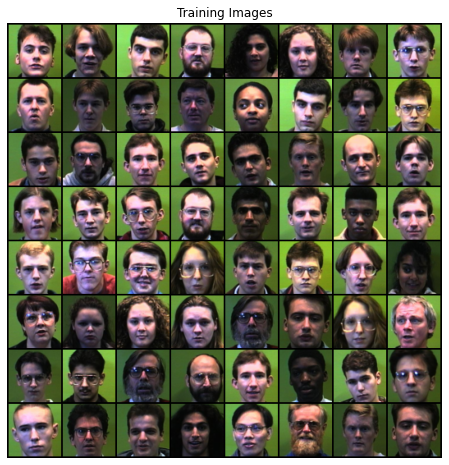

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    else:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [0]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z
            nn.Linear(nz,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 12288),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
#Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Sequential(
  (0): Linear(in_features=100, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=1024, out_features=12288, bias=True)
  (5): Tanh()
)


### Discriminator

In [0]:
# Create the Discriminator
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            Flatten(),
            nn.Linear(12288,256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256,256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256,1)
        )

    def forward(self, input):
        return self.main(input)

In [11]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=12288, out_features=256, bias=True)
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): LeakyReLU(negative_slope=0.01, inplace=True)
  (5): Linear(in_features=256, out_features=1, bias=True)
)


### Loss function and Optimizer

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 12 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/35][0/48]	Loss_D: 1.7170	Loss_G: 4.7619	D(x): 0.5476	D(G(z)): 0.5646 / 0.0120
[0/35][12/48]	Loss_D: 0.1863	Loss_G: 9.3324	D(x): 0.9799	D(G(z)): 0.1399 / 0.0001
[0/35][24/48]	Loss_D: 0.0435	Loss_G: 9.7538	D(x): 0.9684	D(G(z)): 0.0007 / 0.0001
[0/35][36/48]	Loss_D: 0.4312	Loss_G: 19.3485	D(x): 0.9835	D(G(z)): 0.2810 / 0.0000
[1/35][0/48]	Loss_D: 0.0169	Loss_G: 6.7219	D(x): 0.9987	D(G(z)): 0.0151 / 0.0049
[1/35][12/48]	Loss_D: 0.0074	Loss_G: 23.4510	D(x): 0.9941	D(G(z)): 0.0000 / 0.0000
[1/35][24/48]	Loss_D: 0.0272	Loss_G: 20.7508	D(x): 0.9746	D(G(z)): 0.0000 / 0.0000
[1/35][36/48]	Loss_D: 4.1133	Loss_G: 24.8791	D(x): 0.9986	D(G(z)): 0.8790 / 0.0000
[2/35][0/48]	Loss_D: 0.4319	Loss_G: 9.9502	D(x): 0.8945	D(G(z)): 0.1743 / 0.0001
[2/35][12/48]	Loss_D: 0.1376	Loss_G: 7.4643	D(x): 0.9095	D(G(z)): 0.0242 / 0.0012
[2/35][24/48]	Loss_D: 0.1998	Loss_G: 4.7860	D(x): 0.8897	D(G(z)): 0.0403 / 0.0238
[2/35][36/48]	Loss_D: 0.3597	Loss_G: 6.6434	D(x): 0.7701	D(G(z)): 0.007

### Generator and Discriminator Loss During Training

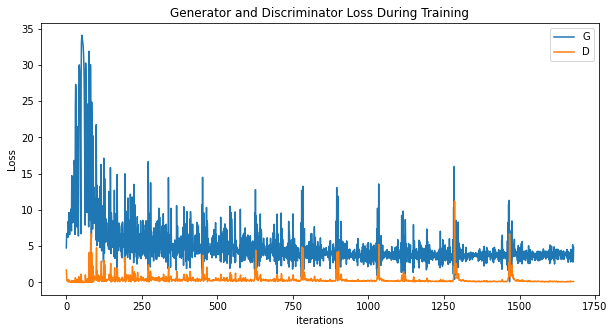

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Results

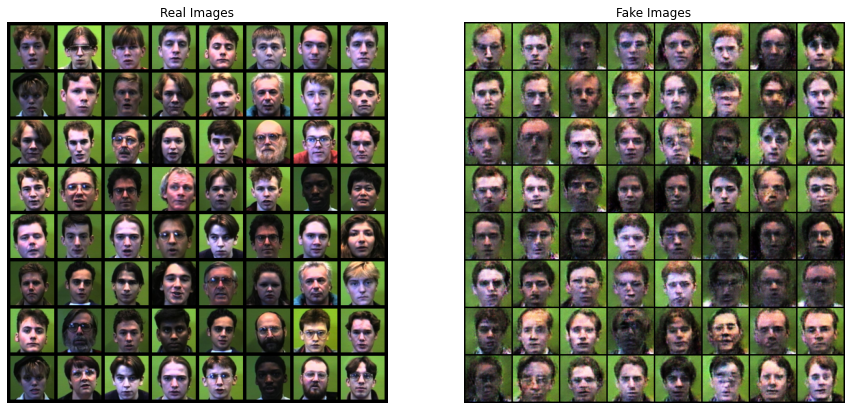

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()